### Sales Activity Analysis using Classification 

Take a wrangled data set that includes sales team activity, prospect activity, prospect firmographic information, and a manually applied prospect score to predict sales opportunity outcomes.

In [5]:
import sys, os
sys.path.append(os.environ['minotaur'])

import seaborn as sns
import sklearn
from sklearn.model_selection import cross_val_score


import yaml

%matplotlib inline
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import patsy
import statsmodels.api as sm

from pylab import rcParams
rcParams['figure.figsize'] = 14,3

from dbs import redshift
redshift.connect()

from __future__ import division

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, scale
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline



### Import data

In [7]:
#final is not normalized. need to import finalnorm for normalized activity dataframe
X = pd.read_csv('final.csv',header=0,index_col=0).copy()
X.head()

y = X['is_won'].copy()
del X['is_won']


In [8]:
#calculate statistics on below 
# this is where error lies, further y is from y_pred. look into calculating error
# abs(y_pred - y).mean()

# calculating maximum absolute difference
# mean abs dif is .32 and max is 1.24. on average we are 30% away from the truth
# this is quite a bad model. need to train. a good model is closer to .1 std. 60% of answer will be in 40% of correct answer
# cross validation score. going to matter to us the most. its going to tell us whether there was a stasitcally sig differenece between email, call


# try to run log reg 
# it wouldn't be too bad to gain from log reg a basic sense of what to expect
# not be shocked if you run a tree based alg and it outperforms the others signifc
# in most cased tree based algorithms tend to do a really good job
# tree based ....
    #

### Logistic Regression Exploration

In [9]:
# Setup the pipeline
steps = [('scaler', StandardScaler()),
        ('dec', LogisticRegression())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the pipeline to the training set: knn_scaled
log_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a Log classifier to the unscaled data
log_unscaled = LogisticRegression().fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(log_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(log_unscaled.score(X_test, y_test)))

Accuracy with Scaling: 0.774705164701098
Accuracy without Scaling: 0.7759251728344856


In [14]:
#Scale X
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X),columns = X.columns)

# Create the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
weights = {}
param_grid = {'C': c_space, 
              'penalty': ['l1', 'l2']
              #'class_weight': ['balanced']
             }

# Instantiate the logistic regression classifier: logreg
logreg = LogisticRegression()

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=.3,random_state=42)

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg,param_grid,cv=5)

# Fit it to the training data
logreg_cv.fit(X_train,y_train)

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))


Tuned Logistic Regression Parameter: {'C': 3.7275937203149381, 'penalty': 'l2'}
Tuned Logistic Regression Accuracy: 0.7787656903765691


In [15]:
# looks like logistic regression is giving us the best accuracy and coverage across targets
#

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)


# Create the classifier: Logistic Regression
logreg = LogisticRegression(C= 3.7275937203149381, penalty= 'l2')

# Fit the classifier to the training data
logreg.fit(X_train,y_train)

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1841   53]
 [ 498   67]]
             precision    recall  f1-score   support

      False       0.79      0.97      0.87      1894
       True       0.56      0.12      0.20       565

avg / total       0.73      0.78      0.71      2459



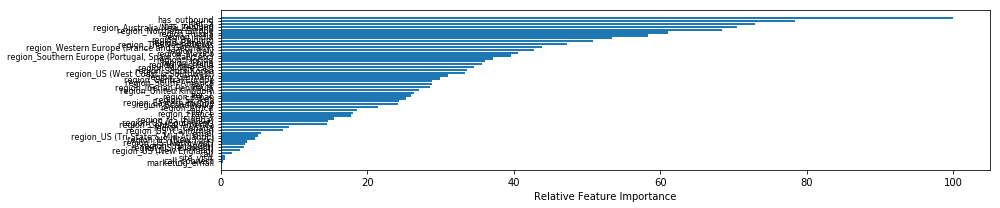

In [16]:
# Feature Importance

feature_importance = abs(logreg.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5


featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

#### Decision Tree Classifier

In [17]:
# Setup the pipeline
steps = [('scaler', StandardScaler()),
        ('dec', DecisionTreeClassifier())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the pipeline to the training set: knn_scaled
dec_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a k-NN classifier to the unscaled data
dec_unscaled = DecisionTreeClassifier().fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(dec_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(dec_unscaled.score(X_test, y_test)))

Accuracy with Scaling: 0.6897112647417649
Accuracy without Scaling: 0.6905246034973567


In [23]:
# Setup the hyperparameter grid
param_dist = {"max_depth": [3,5,10,20,50],
              "max_features": randint(1, 20),
              "min_samples_leaf": randint(1, 20),
              "criterion": ["gini", "entropy"],
              "class_weight": ['balanced']}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': 15, 'min_samples_leaf': 19}
Best score is 0.6063453325198291


In [25]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42)


# Create the classifier: tree
tree = DecisionTreeClassifier(criterion= 'gini', max_depth= 10, max_features= 15, min_samples_leaf= 19, class_weight="balanced")

# Fit the classifier to the training data
tree.fit(X_train,y_train)

# Predict the labels of the test set: y_pred
y_pred = tree.predict(X_test)


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1573  949]
 [ 308  448]]
             precision    recall  f1-score   support

      False       0.84      0.62      0.71      2522
       True       0.32      0.59      0.42       756

avg / total       0.72      0.62      0.65      3278



#### Random Forest Classifier

In [26]:
# Setup the pipeline
steps = [('scaler', StandardScaler()),
        ('dec', RandomForestClassifier())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the pipeline to the training set: knn_scaled
dec_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a k-NN classifier to the unscaled data
dec_unscaled = RandomForestClassifier().fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(dec_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(dec_unscaled.score(X_test, y_test)))

Accuracy with Scaling: 0.7539650264335096
Accuracy without Scaling: 0.7519316795445303


In [27]:
# Setup the hyperparameter grid
param_dist = {"n_estimators": [100,200,500,700,1000],
              "max_features": ['auto', 'sqrt', 'log2'],
              "n_jobs": [-1,1,5,10],
              "class_weight": ['balanced']}

# Instantiate a Decision Tree classifier: tree
forest = RandomForestClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
forest_cv = GridSearchCV(forest, param_dist, cv=5)

# Fit it to the data
forest_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(forest_cv.best_params_))
print("Best score is {}".format(forest_cv.best_score_))

Tuned Decision Tree Parameters: {'class_weight': 'balanced', 'max_features': 'log2', 'n_estimators': 1000, 'n_jobs': -1}
Best score is 0.7266625991458207


In [28]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42)


# Create the classifier: tree
forest = RandomForestClassifier(n_estimators=1000, max_features='log2', class_weight="balanced", n_jobs= -1)

# Fit the classifier to the training data
forest.fit(X_train,y_train)

# Predict the labels of the test set: y_pred
y_pred = forest.predict(X_test)


print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2256  266]
 [ 602  154]]
             precision    recall  f1-score   support

      False       0.79      0.89      0.84      2522
       True       0.37      0.20      0.26       756

avg / total       0.69      0.74      0.71      3278



In [8]:
# This looks to be like the best model when it comes to prediction
# can't use mse for classification 
# metrics for classification would usually be accuracy precision and recall
# need to look at the metrics submodule in scikit learn to see what to use for classification

mse = sklearn.metrics.mean_squared_error(y_test, y_predtrain)
print('classification score:\n{}'
     .format(log.score(X_test,y_test)))

print('standard deviation between predicted and test:\n{}'
     .format(np.std(y_predtrain - y_test)))
print('intercept:\n{}'
     .format(log.intercept_))
print('coeficient:\n{}'
     .format(log.coef_))

regression score:
0.7609903991915109
sqrt mean squared error:
0.48888608162688485
standard deviation between predicted and test:
0.42647861790464464
intercept:
[ 0.43149793]
coeficient:
[[-0.02493372 -0.05080185  0.11319756 -0.01255302  0.03816151 -0.31220943
   0.         -1.15843405 -0.64652992 -0.45989147  0.11136223  0.23134687
  -0.02072864 -0.15564507 -0.35402545 -0.26082667 -0.09285972 -0.49028057
  -0.46860501 -0.48543456 -0.81637557 -0.131937   -0.4043737  -0.25247481
  -0.8044695  -0.70258579 -0.47579441  0.14147333 -0.4400523  -0.26872919
  -0.34069848 -0.66647594  0.51084196  0.30498244  0.215202    0.4158395
   0.46254677  0.66665776  0.55875354  0.56225845  0.40799347 -0.62231252
  -0.14234815 -0.39321318 -0.12365041 -0.38806477 -0.35339201 -0.62875287
  -1.71774314 -1.13486059 -1.63313624]]


/usr/local/lib/python3.6/site-packages/sklearn/metrics/regression.py:232: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/usr/local/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '-' operator is not supported by numexpr for the bool dtype, use '^' instead
  unsupported[op_str]))


In [51]:
sgd = SGDRegressor(n_iter=100000, eta0=.001)
sgd = sgd.fit(X_train,y_train)
y_predtrain = sgd.predict(X_test)

In [52]:
# This looks to be like the best model when it comes to prediction
mse = sklearn.metrics.mean_squared_error(y_test, y_predtrain)
print('regression score:\n{}'
     .format(sgd.score(X_test,y_test)))
print('sqrt mean squared error:\n{}'
     .format(np.sqrt((mse))))
print('standard deviation between predicted and test:\n{}'
     .format(np.std(y_predtrain - y_test)))
print('intercept:\n{}'
     .format(sgd.intercept_))
print('coeficient:\n{}'
     .format(sgd.coef_))

regression score:
0.08653183192333047
sqrt mean squared error:
0.39877807528040426
standard deviation between predicted and test:
0.3987677621748045
intercept:
[ 0.62027828]
coeficient:
[-0.00730749 -0.00502487  0.02371149 -0.00360362  0.00634413 -0.10157257
 -0.16819146 -0.20659486 -0.15704391 -0.2241356  -0.04989972  0.06506618
 -0.04421896 -0.0896196  -0.08797783  0.         -0.06213647 -0.12581416
 -0.13641663 -0.13987223 -0.16175407 -0.04049207 -0.0737324  -0.11118955
 -0.24208288 -0.18335178 -0.13228822 -0.01856615 -0.10298998 -0.08876873
 -0.0424064  -0.11430524  0.04046541  0.07996187 -0.0050805   0.01828288
  0.02247721  0.120929    0.02924236  0.05375098  0.05466915 -0.10354552
 -0.08667022 -0.10054563 -0.03605202 -0.05537326 -0.03530105 -0.08436579
 -0.24452003 -0.26813433 -0.34442953]


In [ ]:
plt.scatter(X_test.call,y_predtrain)

###  Cross Validate the Models

In [ ]:
# a good score is close to 1
cv = cross_val_score(SGDRegressor(n_iter=1000), X, y, cv=10)
cv.mean()

In [ ]:
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5, random_state=0)

# a good score is close to 1
print(SGDRegressor(n_iter=1000).fit(X2, y2).score(X1, y1))
print(SGDRegressor(n_iter=1000).fit(X1, y1).score(X2, y2))

In [ ]:
# a good score is close to 1
cv = cross_val_score(sgd, X, y, cv=10)
cv.mean()

In [ ]:
# Why is this score different than the one above????
print(sgd.fit(X2, y2).score(X1, y1))
print(sgd.fit(X1, y1).score(X2, y2))

In [ ]:
# look at regression by channel, tier
# need to record data better, so like keep record of progression in analysis
# for columns in column_lists
# so you run through column combinations
# append lists of lists 
# have two columns in list of lists. one member of inner list the other is string representation of model itself, and then two more columns of test and score


In [53]:
column_lists = [
    list(X_train.columns),
    [c for c in X_train.columns if c.startswith('region')],
    [c for c in X_train.columns if c.startswith('tier')],
    [c for c in X_train.columns if c.startswith('has')],
    [c for c in X_train.columns if not c[:3] in ['reg','tie', 'has']]
]
hyperparams = []
for cols in column_lists:
    #training and scoring the model
    #instantiate
   
    X_train_ = X_train[cols]
    X_test_ = X_test[cols]
    sgd = sgd.fit(X_train_,y_train)
    y_predtrain = sgd.predict(X_test_)
    hyperparams.append([cols, str(sgd), sgd.score(X_test_,y_test), sgd.score(X_train_,y_train)])

hype = pd.DataFrame(hyperparams)
hype.columns = ['columns', 'model', 'test_score', 'train_score']
#hype.to_csv('hype.csv')

In [54]:
hype

,columns,model,test_score,train_score
0,"[call, call_connect, email, marketing_email, s...","SGDRegressor(alpha=0.0001, average=False, epsi...",0.086833,0.087838
1,"[region_Africa, region_Australia, region_Austr...","SGDRegressor(alpha=0.0001, average=False, epsi...",0.024940,0.036787
2,"[tier_1, tier_2, tier_3, tier_4, tier_5]","SGDRegressor(alpha=0.0001, average=False, epsi...",0.003444,0.003574
3,"[has_inbound, has_outbound]","SGDRegressor(alpha=0.0001, average=False, epsi...",0.025238,0.020771
4,"[call, call_connect, email, marketing_email, s...","SGDRegressor(alpha=0.0001, average=False, epsi...",0.047427,0.041817


In [ ]:
#explore data and models. change the models, sgd.coef_ attributes of  

In [ ]:
sgd = sgd.fit(X_train,y_train)
#confirm that this is a safe mapping
col = pd.DataFrame(sgd.coef_,X_train.columns)

In [ ]:
#scatterplot normalized email and site_visits relative to cvr
#are we doing anything continuos such as days to close
#will be confounding because longer means more email
#pair of overlaid histograms of site_visits and emails
#bodyplot exercise
#degree of separation between those 2 
#two histograms for email. one is won, one is lost
#bimodal distribution because it has two modes/peaks
#separation between those modes/peaks should be reflexive of the slopes
# subtraction of the means of difference
col.sort_values(0,ascending=False)

In [ ]:
# only way to sus out inbound/outbound move back to one columns. it would show that slope being more meaningful
# subtract inbound from outbound slope and try to anticipate what the model is going to find for this new combined single value
# assuming outbound to 1
# -0.07209099999999996 is what it should be after combining
-0.394433 - -0.322342


In [ ]:
activity = X.loc[:,['marketing_email','email','call','call_connect','site_visit']]
un = activity.unstack()
un = pd.DataFrame(un)
un = un.reset_index(level=1,drop=True)
un['type'] = un.index
un = un.rename(columns={0: 'coef'})
un.head()
print()

In [ ]:
_ = sns.boxplot(x='type',y='coef',data=un)
_ = plt.xlabel('type')
_ = plt.ylabel('coef')
plt.show()